In [79]:
#Librerias
import cv2
import matplotlib.pyplot as plt
import numpy as np


In [80]:
def remove_shadow(img):
    rgb_planes = cv2.split(img)

    result_planes = []
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 21)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        result_planes.append(diff_img)
        result_norm_planes.append(norm_img)

    result_norm = cv2.merge(result_norm_planes)

    return result_norm


In [81]:

def bgremove2(myimage):

    ###REMOVE BACKGROUND###
    #input: imagen original
    #output: imagen con fondo blanco
    #######################
    #resultNorm = remove_shadow(myimage)
    myimage_grey = cv2.cvtColor(myimage, cv2.COLOR_BGR2GRAY)

    #Eliminar sombra
    th = cv2.adaptiveThreshold(myimage_grey,255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,11,2)
 
    ret,baseline = cv2.threshold(myimage_grey,127,255,cv2.THRESH_TRUNC)
 
    ret,background = cv2.threshold(baseline,126,255,cv2.THRESH_BINARY)
 
    ret,foreground = cv2.threshold(baseline,126,255,cv2.THRESH_BINARY_INV)
 
    foreground = cv2.bitwise_and(myimage,myimage, mask=foreground)  # Update foreground with bitwise_and to extract real foreground
 
    # Convert black and white back into 3 channel greyscale
    background = cv2.cvtColor(background, cv2.COLOR_GRAY2BGR)
 
    # Combine the background and foreground to obtain our final image
    finalimage = background+foreground
    finalImage = cv2.cvtColor(finalimage, cv2.COLOR_BGR2RGB)
    return finalimage

In [82]:
def clasificarImagen(original):
    im_rgb_norm = remove_shadow(original)

    im_rgb = bgremove2(im_rgb_norm)
    
    #Valores de la saturación y escasez de luz
    myimage_hsv = cv2.cvtColor(im_rgb, cv2.COLOR_BGR2HSV)
    meanv = cv2.mean(myimage_hsv)   #Media de hsv
    
    print(meanv[2]) 
    color = (0,0,0)
    nombre = ""
    if (meanv[2]>235 and meanv[2]<=242):
        nombre = 'No aprobechable'
        color = (0,0,0)
        print('No aprobechable')
    elif (meanv[2]<=234 and meanv[2]>=220):
        nombre = 'Organico'
        color = (0,0,255)
        print('Organico')
    else:
        nombre = 'Aprobechable'
        color = (255,255,255)
        print('Aprobechable')
    
    #ENCONTRAR EL CENTROIDE DEL OBJETO
    # Convert BGR to grayscale:
    grayscaleImage = cv2.cvtColor(im_rgb, cv2.COLOR_BGR2GRAY)
    # Threshold via Otsu + bias adjustment:
    threshValue, binaryImage = cv2.threshold(grayscaleImage, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    # Apply an erosion + dilation to get rid of small noise:
    # Set kernel (structuring element) size:
    kernelSize = 3

    # Set operation iterations:
    opIterations = 3

    # Get the structuring element:
    maxKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernelSize, kernelSize))

    # Perform closing:
    openingImage = cv2.morphologyEx(binaryImage, cv2.MORPH_OPEN, maxKernel, None, None, opIterations, cv2.BORDER_REFLECT101)

    # Calculate the moments
    imageMoments = cv2.moments(openingImage)

    # Compute centroid
    cx = int(imageMoments['m10']/imageMoments['m00'])
    cy = int(imageMoments['m01']/imageMoments['m00'])

    # Print the point:
    # print("Cx: "+str(cx))
    # print("Cy: "+str(cy))

    # Draw centroid onto BGR image:
    centroid_img = cv2.line(original, (cx,cy), (cx,cy), color, 15)
    centroid_img = cv2.putText(original, nombre, (cx - 100, cy - 20),cv2.FONT_HERSHEY_SIMPLEX, 0.7,color, 2)

    #Return classifiedd img
    return centroid_img

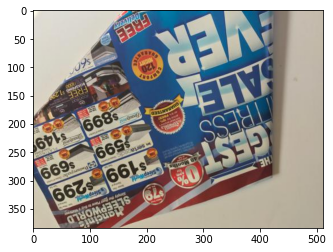

In [83]:
#Cargar imagen
image = cv2.imread('images/paper101.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

234.69890848795572
Aprobechable


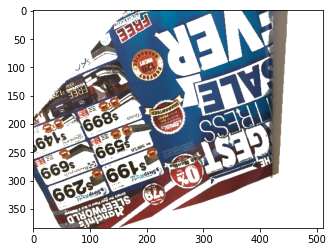

In [84]:
#Remove background
nobackgroundImg = bgremove2(image)
#classify img
classified = clasificarImagen(image)

plt.imshow(nobackgroundImg)

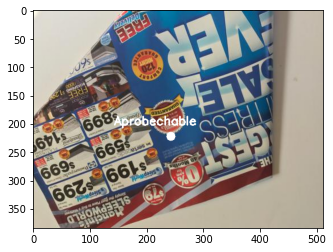

In [85]:
plt.imshow(classified)

In [86]:
#Hacerlo con todas las imagenes
glass = ['glass100.jpg','glass110.jpg','glass124.jpg']
metal = ['metal102.jpg','metal124.jpg']
organic = ['organic1.jpg','organic4.jpg','trash101.jpg','trash55.jpg','trash7.jpg']
paper = ['paper101.jpg','paper106.jpg']
plastic = ['plastic10.jpg','plastic103.jpg','plastic109.jpg']
paquetes = ['trash111.jpg','trash115.jpg']

total_basura = glass+metal+organic+paper+plastic+paquetes

#Histograma

#Classify all images
for trash in paper:
    path = 'images/'+trash
    image = cv2.imread(path)
    h,s,v = cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2HSV))
    v = np.ravel(v)
    print(v.shape)




(196608,)
(196608,)


In [87]:
# image = cv2.imread('images/trash115.jpg')
# im,imNorm = remove_shadow(image)
# plt.imshow(imNorm)

(12.926060994466145, 13.619725545247395, 239.03524271647134, 0.0) TRASH115 paquete rojo

(10.347457885742188, 15.971420288085938, 237.4696553548177, 0.0) metal124 lata

(15.204676310221354, 15.270731608072916, 234.10540771484375, 0.0) manzana

(21.754903157552082, 33.959940592447914, 197.41077677408853, 0.0) papel como periodico

(2.835657755533854, 2.455073038736979, 250.2180430094401, 0.0) botella

de 220 a 235 organico verde
de 235 para arriba no aprovechable negro
de 220 para abajo aprovechable



Espacio de color y ver la iluminación
Centro de masa para decir en donde va

negro residuos inservibles

verde compostaje/organicos

blanco aprovechables tipo vidrio, papel, latas...

trasformación a espacio de hering